## Cadena de Supermercados Good Seed

## Carga los datos y librerías

El conjunto de datos se almacena en la carpeta `/datasets/faces/` 
- La carpeta `final_files` con 7600 fotos 
- El archivo `labels.csv` con etiquetas, con dos columnas: `file_name` y `real_age` 
Dado que el número de archivos de imágenes es bastante elevado, se recomienda evitar leerlos todos a la vez, ya que esto consumiría muchos recursos computacionales. Te recomendamos crear un generador con ImageDataGenerator. Este método se explicó en el capítulo 3, lección 7 de este curso.



In [1]:
#Importar librerías
import pandas as pd
import matplotlib.pyplot as plt 

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
#Cargar archivo csv
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
#Cargar imágenes
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## Análisis Exploratorio de Datos

In [4]:
#Vista preliminar
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [5]:
#Información general del data set
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


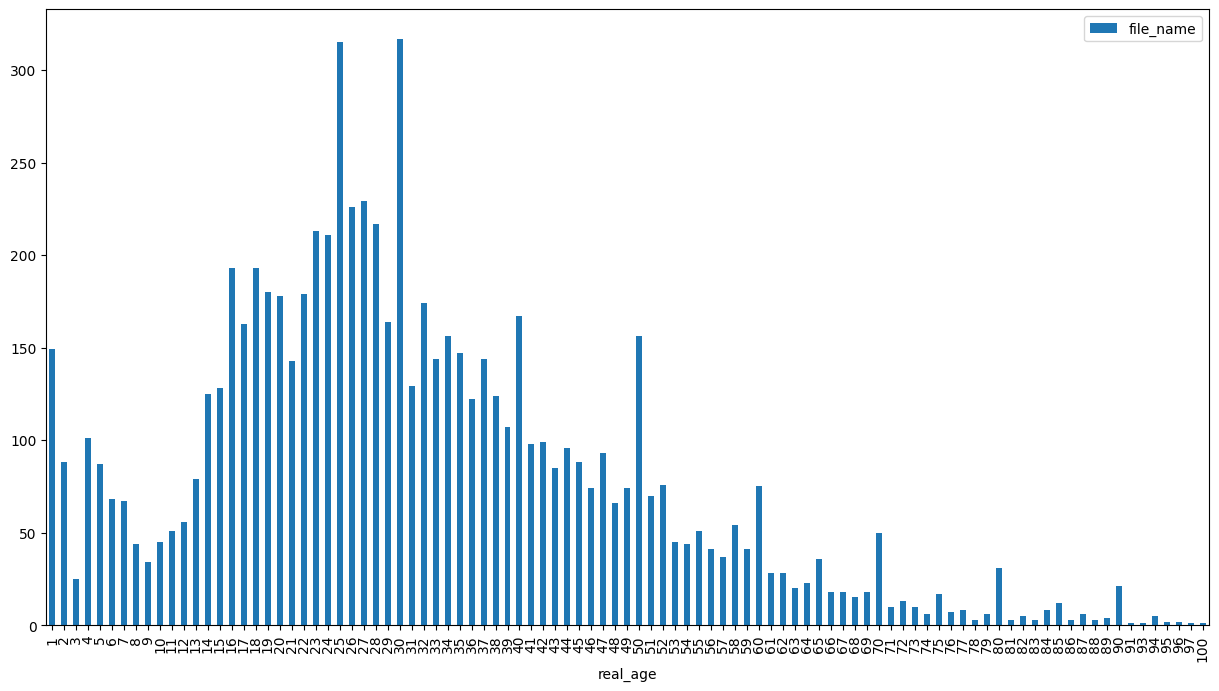

In [6]:
labels.groupby('real_age').count().plot(kind='bar',figsize=(15,8))
plt.show()

In [7]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

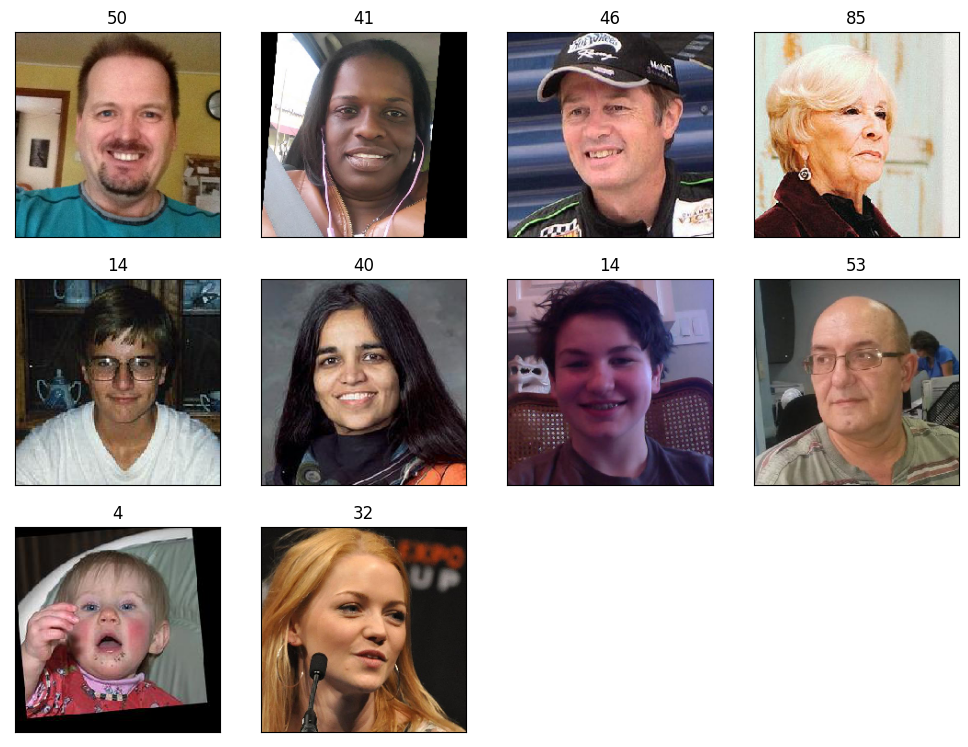

In [8]:
features, target = next(train_gen_flow) 
# vista previa de primeras 15 imágenes con sus respectivas edades
fig = plt.figure(figsize=(10,10)) 

for i in range(10): 
    fig.add_subplot(4, 4, i+1) 
    plt.imshow(features[i]) 
    plt.title(target[i])
    
    #quitar ejes y colocar las imágenes cerca 
    plt.xticks([]) 
    plt.yticks([]) 
    plt.tight_layout() 

### Conclusiones

Teniendo en cuenta que el objetivo es reconocer a personas adultas el dataset que tenemos nos va ayudar a eso ya que el 80% de los datos corresponde a personas mayores de 20 años

## Modelado

Define las funciones necesarias para entrenar tu modelo en la plataforma GPU y crea un solo script que las contenga todas junto con la sección de inicialización.

Para facilitar esta tarea, puedes definirlas en este notebook y ejecutar un código listo en la siguiente sección para componer automáticamente el script.

Los revisores del proyecto también verificarán las definiciones a continuación, para que puedan comprender cómo construiste el modelo.

In [9]:
def load_train(path):
    
    """
    Carga la parte de entrenamiento del conjunto de datos desde la ruta.
    """
    
    #cargar los labels
    labels = pd.read_csv(path + 'labels.csv')
    
    #cargar las imagenes
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path +'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345) 

    return train_gen_flow

In [10]:
def load_test(path):
    
    """
    Carga la parte de validación/prueba del conjunto de datos desde la ruta
    """
    
   #cargar los labels
    labels = pd.read_csv(path + 'labels.csv')
    
    #cargar las imagenes
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    test_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=(path +'final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)  

    return test_gen_flow

In [11]:
def create_model(input_shape):
    
    """
    Define el modelo
    """
    
    backbone = ResNet50(
       input_shape=input_shape, 
       weights='imagenet', 
       include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    
    #Una neurona de salida, solo se espera la edad
    model.add(Dense(1, activation='relu'))
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001), 
        loss="mean_squared_error", 
        metrics=["mae"])
    
   

    return model

In [12]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Entrena el modelo dados los parámetros
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit( train_data, 
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs, 
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2)

    return model

## Prepara el script para ejecutarlo en la plataforma GPU

Una vez que hayas definido las funciones necesarias, puedes redactar un script para la plataforma GPU, descargarlo a través del menú "File|Open..." (Archivo|Abrir) y cargarlo más tarde para ejecutarlo en la plataforma GPU.

Nota: el script debe incluir también la sección de inicialización. A continuación se muestra un ejemplo.

In [13]:
# prepara un script para ejecutarlo en la plataforma GPU

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### El resultado

Coloca el resultado de la plataforma GPU como una celda Markdown aquí.

Found 5694 validated image filenames.

Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps

Epoch 1/20
178/178 - 65s - loss: 245.0955 - mae: 11.1823 - val_loss: 894.1795 - val_mae: 25.0574

Epoch 2/20
178/178 - 38s - loss: 62.5884 - mae: 6.0004 - val_loss: 947.6217 - val_mae: 25.9671

Epoch 3/20
178/178 - 38s - loss: 31.7947 - mae: 4.2828 - val_loss: 331.6021 - val_mae: 13.3702

Epoch 4/20
178/178 - 38s - loss: 19.6925 - mae: 3.4174 - val_loss: 109.8431 - val_mae: 8.0275

Epoch 5/20
178/178 - 38s - loss: 14.7646 - mae: 2.9938 - val_loss: 86.0103 - val_mae: 6.9398

Epoch 6/20
178/178 - 38s - loss: 12.7118 - mae: 2.7601 - val_loss: 70.8739 - val_mae: 6.3532

Epoch 7/20
178/178 - 38s - loss: 10.9120 - mae: 2.5098 - val_loss: 71.6178 - val_mae: 6.5183

Epoch 8/20
178/178 - 38s - loss: 8.4091 - mae: 2.2008 - val_loss: 70.8441 - val_mae: 6.4877

Epoch 9/20
178/178 - 38s - loss: 7.1094 - mae: 2.0067 - val_loss: 70.6308 - val_mae: 6.3671

Epoch 10/20
178/178 - 38s - loss: 7.0045 - mae: 1.9915 - val_loss: 65.9421 - val_mae: 6.2099

Epoch 11/20
178/178 - 38s - loss: 6.7090 - mae: 1.9431 - val_loss: 76.8608 - val_mae: 6.6062

Epoch 12/20
178/178 - 38s - loss: 6.5722 - mae: 1.9482 - val_loss: 65.8247 - val_mae: 6.0685

Epoch 13/20
178/178 - 38s - loss: 5.8667 - mae: 1.8191 - val_loss: 66.8528 - val_mae: 6.3149

Epoch 14/20
178/178 - 38s - loss: 5.2492 - mae: 1.7317 - val_loss: 68.5052 - val_mae: 6.1672

Epoch 15/20
178/178 - 38s - loss: 5.3717 - mae: 1.7398 - val_loss: 64.1595 - val_mae: 6.0654

Epoch 16/20
178/178 - 38s - loss: 5.4877 - mae: 1.7399 - val_loss: 74.2116 - val_mae: 6.4131

Epoch 17/20
178/178 - 39s - loss: 5.2340 - mae: 1.7160 - val_loss: 75.5454 - val_mae: 6.7340

Epoch 18/20
178/178 - 38s - loss: 5.5712 - mae: 1.7661 - val_loss: 64.6718 - val_mae: 6.0515

Epoch 19/20
178/178 - 38s - loss: 5.9201 - mae: 1.8039 - val_loss: 65.5080 - val_mae: 6.1561

Epoch 20/20
178/178 - 38s - loss: 5.5354 - mae: 1.7689 - val_loss: 68.3448 - val_mae: 6.1393

60/60 - 9s - loss: 68.3448 - mae: 6.1393

Test MAE: 6.1393

## Conclusiones

Se obtiene un Error Medio absoluto de 6.1393, el cual se podría mejorar si tendríamos más imágenes correspondientes a personas menores de edad que según el análisis exploratorio de datos realizado solamente representa alrededor del 25%